In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import folium
import os
%matplotlib inline
sns.set(style='whitegrid')


In [2]:
import sys
print(sys.executable)


c:\Program Files\Python39\python.exe


In [3]:
train = pd.read_csv('../data/climate_modeling_data.csv')
test = train.sample(frac=0.3, random_state=42).copy()
samplesubmission = test[['year', 'week_no']].copy()
samplesubmission['emission'] = np.nan
samplesubmission.head()


,year,week_no,emission
521,2020,11,NaN
737,2020,24,NaN
740,2020,50,NaN
660,2019,5,NaN
411,2019,21,NaN


In [4]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample submission shape:", samplesubmission.shape)
print("Train/Test Ratio:", test.shape[0] / (train.shape[0] + test.shape[0]))


Train shape: (1000, 9)
Test shape: (300, 9)
Sample submission shape: (300, 3)
Train/Test Ratio: 0.23076923076923078


In [5]:
train.describe(include='all')


,year,week_no,latitude,longitude,CO2_emission,temperature_anomaly,sea_level_rise,precipitation,solar_radiation
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2020.036000,26.749000,1.697384,-5.701946,402.788190,1.001807,3.200300,993.687200,200.992820
std,0.816928,15.215502,52.343616,102.442698,49.223848,0.203881,0.514506,148.346631,25.798138
min,2019.000000,1.000000,-89.969451,-179.966755,238.790000,0.417000,0.960000,488.200000,118.950000
25%,2019.000000,13.000000,-43.944054,-96.200449,368.690000,0.861750,2.850000,894.600000,182.967500
50%,2020.000000,27.000000,4.124985,-6.343229,404.200000,1.002000,3.200000,987.150000,200.610000
75%,2021.000000,40.250000,47.251898,81.541743,434.575000,1.134000,3.540000,1087.675000,218.415000
max,2021.000000,52.000000,89.929034,179.542143,558.080000,1.737000,4.950000,1448.600000,294.840000


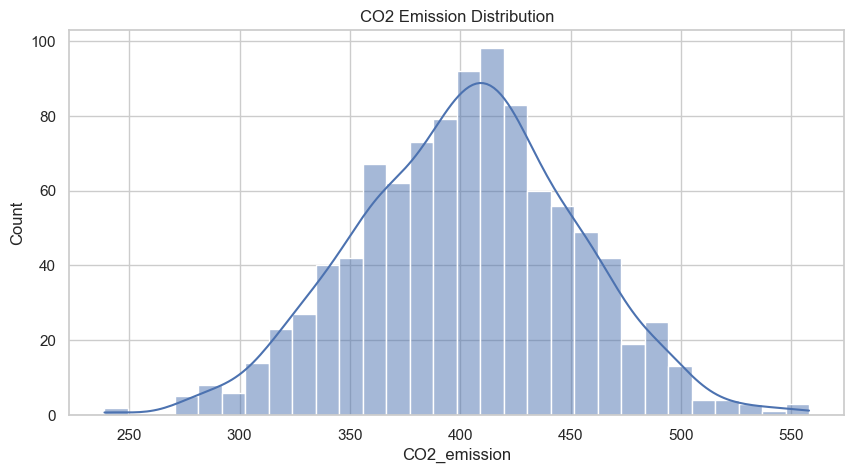

In [6]:
plt.figure(figsize=(10,5))
sns.histplot(train['CO2_emission'], bins=30, kde=True)
plt.title("CO2 Emission Distribution")
plt.show()


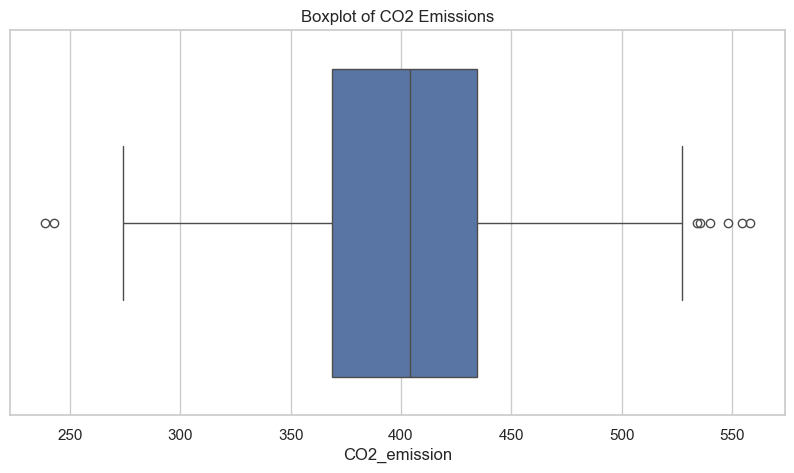

In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=train["CO2_emission"])
plt.title("Boxplot of CO2 Emissions")
plt.show()


In [8]:
train_coords = train.drop_duplicates(subset=['latitude', 'longitude']).copy()
test_coords = test.drop_duplicates(subset=['latitude', 'longitude']).copy()
train_coords['set_type'] = 'train'
test_coords['set_type'] = 'test'
all_data = pd.concat([train_coords, test_coords], ignore_index=True)

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(all_data[['latitude', 'longitude', 'set_type']], geometry=geometry)
geo_df.head()


,latitude,longitude,set_type,geometry
0,-59.761942,-100.250746,train,POINT (-100.25075 -59.76194)
1,13.299156,86.333838,train,POINT (86.33384 13.29916)
2,57.903372,-22.995336,train,POINT (-22.99534 57.90337)
3,-18.900236,122.439621,train,POINT (122.43962 -18.90024)
4,-84.693187,-131.649900,train,POINT (-131.6499 -84.69319)


In [9]:
all_data_map = folium.Map(prefer_canvas=True)
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]
for i, coordinates in enumerate(geo_df_list):
    color = "green" if geo_df.set_type.iloc[i] == "train" else "orange"
    folium.CircleMarker(
        location=coordinates,
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=f"Set: {geo_df.set_type.iloc[i]}",
    ).add_to(all_data_map)
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map


In [10]:
print("Missing in train:", train.isnull().sum().any())
print("Missing in test:", test.isnull().sum().any())
print("Duplicate rows in train:", train.duplicated().sum())
print("Duplicate rows in test:", test.duplicated().sum())


Missing in train: False
Missing in test: False
Duplicate rows in train: 0
Duplicate rows in test: 0


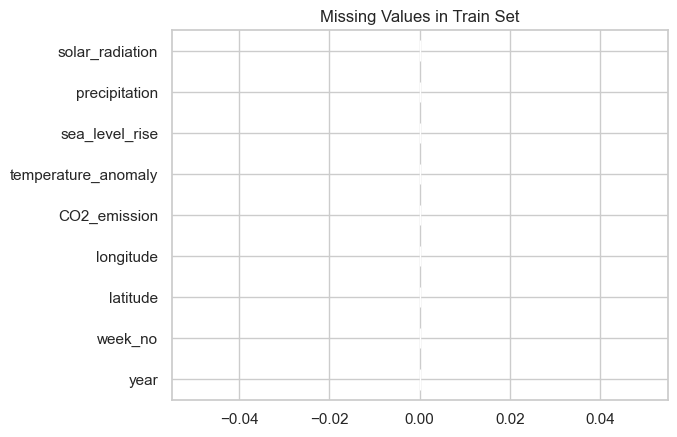

In [11]:
train.isnull().sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Missing Values in Train Set")
plt.show()


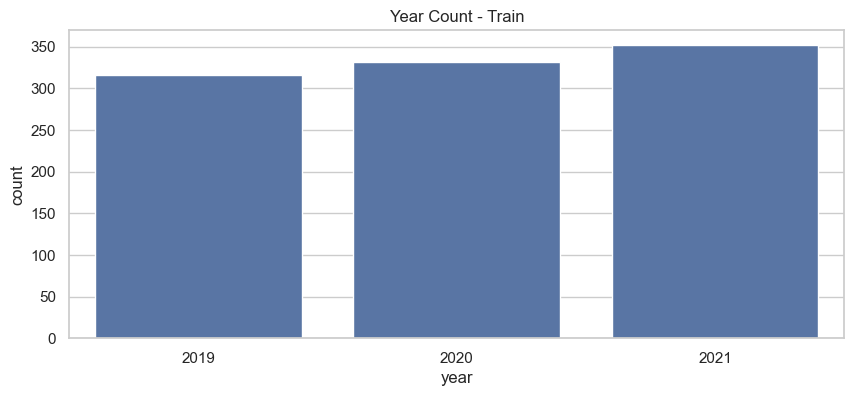

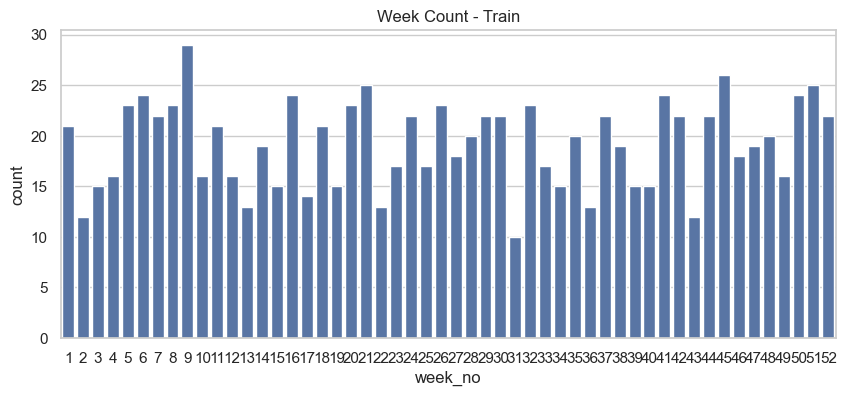

In [12]:
plt.figure(figsize=(10, 4))
sns.countplot(data=train, x='year')
plt.title("Year Count - Train")
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(data=train, x='week_no')
plt.title("Week Count - Train")
plt.show()


Top correlated features:\n CO2_emission           1.000000
solar_radiation        0.051357
temperature_anomaly    0.028072
sea_level_rise        -0.003363
latitude              -0.004702
longitude             -0.018789
year                  -0.035707
week_no               -0.052371
precipitation         -0.056004
Name: CO2_emission, dtype: float64


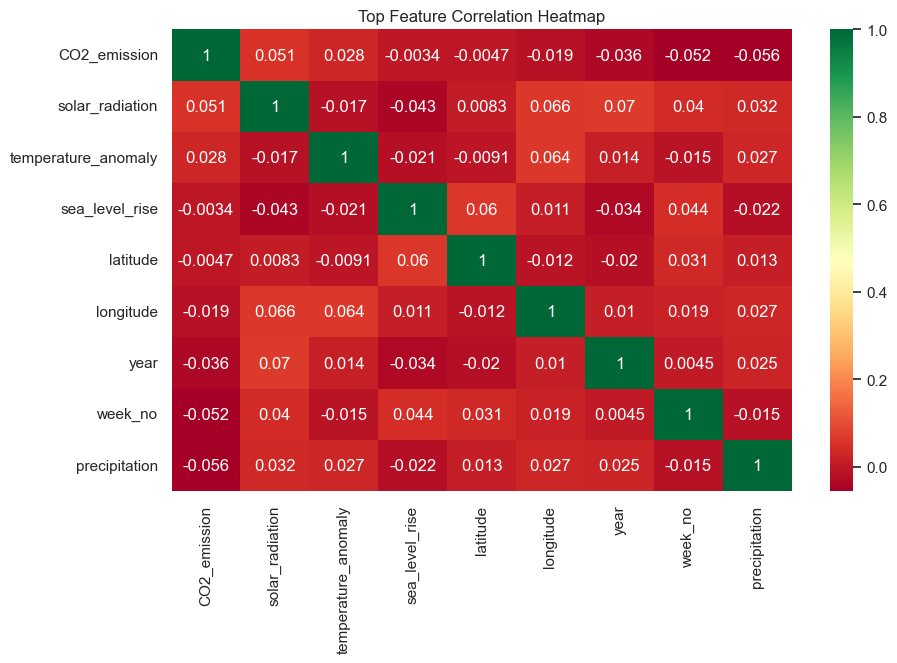

In [13]:
corr = train.corr()
top_corr = corr['CO2_emission'].sort_values(ascending=False).head(10)
print("Top correlated features:\\n", top_corr)

plt.figure(figsize=(10, 6))
sns.heatmap(train[top_corr.index].corr(), annot=True, cmap='RdYlGn')
plt.title("Top Feature Correlation Heatmap")
plt.show()


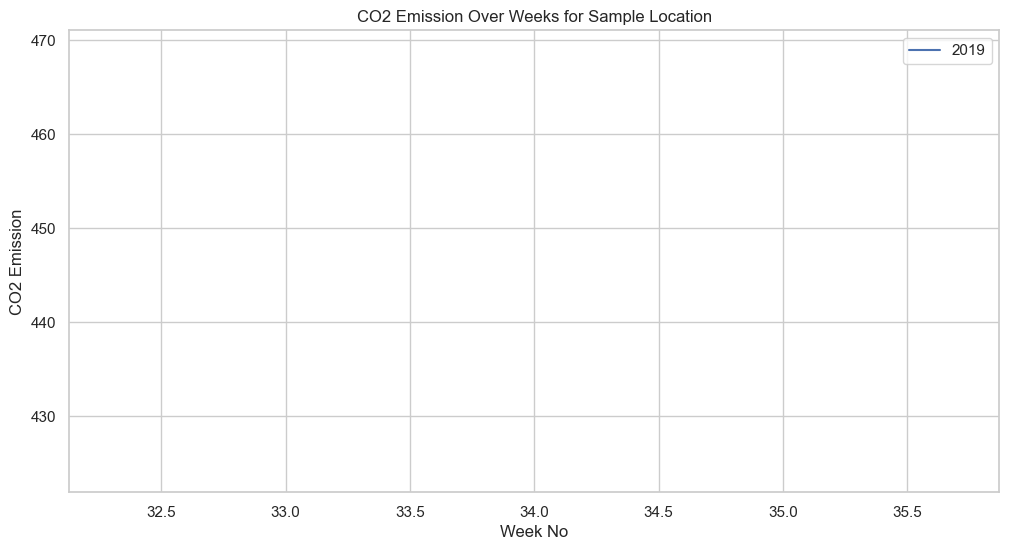

In [14]:
sample_loc = train[(train['latitude'].round(1) == train['latitude'].round(1).iloc[0]) & 
                (train['longitude'].round(1) == train['longitude'].round(1).iloc[0])]

plt.figure(figsize=(12, 6))
for year in sample_loc['year'].unique():
    df_year = sample_loc[sample_loc['year'] == year]
    sns.lineplot(x=df_year['week_no'], y=df_year['CO2_emission'], label=str(year))

plt.title("CO2 Emission Over Weeks for Sample Location")
plt.xlabel("Week No")
plt.ylabel("CO2 Emission")
plt.legend()
plt.show()


In [17]:
import joblib
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Simulate future data
future_data = test.drop(columns=["temperature_anomaly"], errors="ignore").copy().sample(5)

model = joblib.load('../models/trained_model.pkl')
scaler = StandardScaler()
scaled = scaler.fit_transform(future_data)

future_preds = model.predict(scaled)
print("Future Predictions:\n", future_preds)


Future Predictions:
 [0.94713 0.99911 1.15167 0.92502 1.05529]
